# **Predicting Alternating Sequences using RNN**

* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**

In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# to print status reports
import sys

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

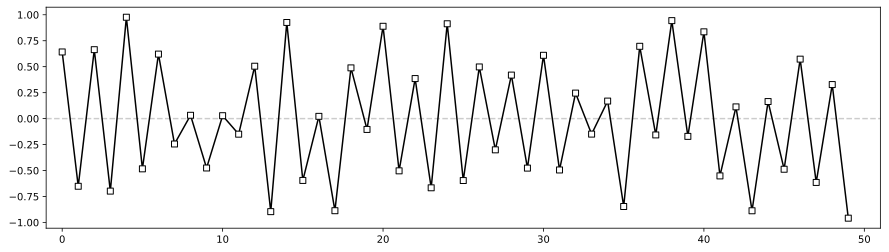

In [2]:
# create temporal sequence data

# import the data
N=50

data=tr.zeros(N)
for i in range(N):
    data[i]=tr.rand(1)*(-1)**i

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[0.8,0.8,0.8])
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

In [3]:
# create a class for DL model

class RNNnet(nn.Module):
    def __init__(self,input_size,num_hidden,num_layers):
        super().__init__()

        # RNN layer
        self.rnn=nn.RNN(input_size,num_hidden,num_layers)

        # linear layer for output
        self.out=nn.Linear(num_hidden,1)

    def forward(self,x):

        # run through the rnn layer
        y,hidden=self.rnn(x)    # no explicit hidden state initialization (default hidden state --> tr.zeros)

        # and the output layer
        y=self.out(y)
        return y,hidden   

In [4]:
# network params
input_size = 1 # "channels" of data
num_hidden = 5 # breadth of the model (no of units in the hidden layer)
num_layers = 1 # depth of the model (no of "stacks" of the hidden layer) 
seqlength  = 9 # number of datapoints used for learning in each segment
batchsize  = 1 # Note: the training code is actually hard-coded to organize data into batchesize=1

# create an instance of the model and inspect 
net=RNNnet(input_size,num_hidden,num_layers)

X=tr.rand(seqlength,batchsize,num_layers)
y,h=net(X)
print(X.shape)
print(y.shape)  # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])


In [7]:
# test the model with some data
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]
print(finalValue)
print(data[seqlength].view(1,1))

lossfun=nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

tensor([[-0.6453]], grad_fn=<SelectBackward0>)
tensor([[-0.4758]])


tensor(0.0287, grad_fn=<MseLossBackward0>)

In [13]:
# Train the model and show performance

# number of training epochs
numepochs=30

# create a new instance of the model (and optimizer!)
net = RNNnet(input_size,num_hidden,num_layers)
optimizer=tr.optim.SGD(net.parameters(),lr=0.001)

# initialize losses
losses = np.zeros(numepochs)
signaccuracy=np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over data segments
    seglosses=[]
    segacc=[]
    hidden_state = tr.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

    for timei in range(N-seqlength):
        # grab a snippet of data
        X=data[timei:timei+seqlength].view(seqlength,1,1) # convert vector to tensor
        y=data[timei+seqlength].view(1,1)

        # forward pass and loss
        yHat,hidden_state=net(X)
        finalValue=yHat[-1]
        loss=lossfun(finalValue,y)   # compare the final value of output

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses from this segment
        seglosses.append(loss.item())

        # also get the sign accuracy
        truesign=np.sign(tr.squeeze(y).numpy())
        predsign=np.sign(tr.squeeze(finalValue).detach().numpy())
        accuracy=100*(truesign==predsign)
        segacc.append(accuracy)

    # average losses from this epoch
    losses[epochi]=np.mean(seglosses)
    signaccuracy[epochi]=np.mean(segacc)

    msg=f'Finished epoch {epochi+1}/{numepochs}'
    sys.stdout.write('\r'+msg)

Finished epoch 30/30

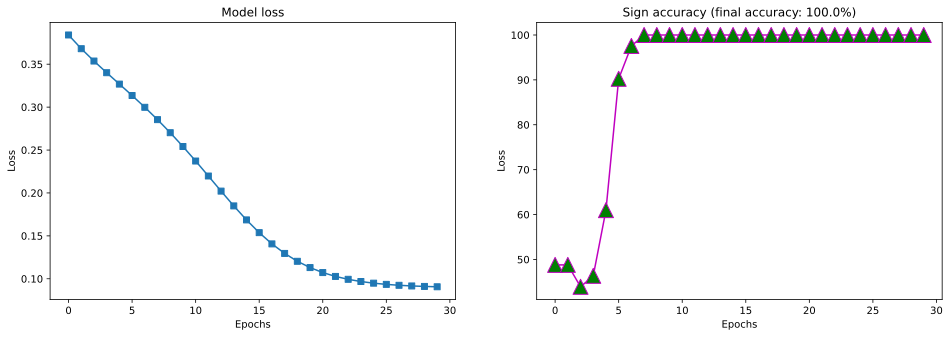

In [14]:
# let's see how did the model do?
fig,ax=plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title(f"Sign accuracy (final accuracy: {signaccuracy[-1]}%)")
plt.show()



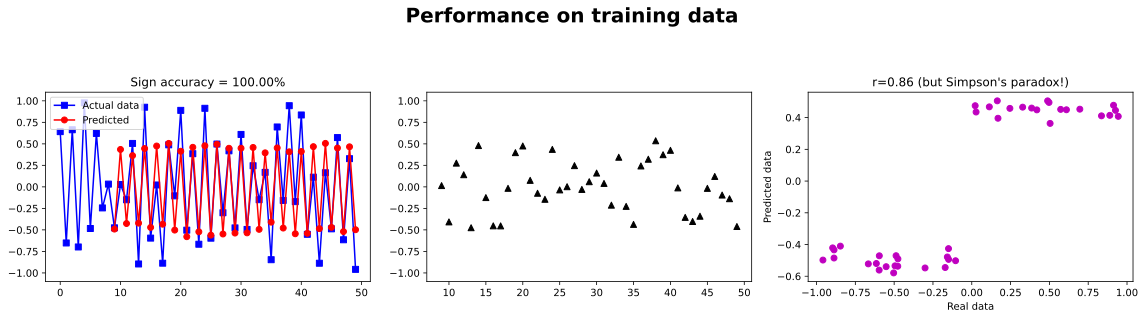

In [18]:
# now test the network

# initialize hidden state
h=np.zeros((N,num_hidden))

# initialize predicted values
yHat=np.zeros(N)
yHat[:]=np.nan
# loop over time segments
for timei in range(N-seqlength):
    # grab a snippet of data
    X=data[timei:timei+seqlength].view(seqlength,1,1)

    # forward pass and loss 
    yy,hh=net(X)
    yHat[timei+seqlength]=yy[-1]
    h[timei+seqlength,:]=hh.detach()

# compute sign-accuracy
truesign=np.sign(data.numpy())
predsign=np.sign(yHat)
signaccuracy=100*np.mean(truesign[seqlength:]==predsign[seqlength:])

## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

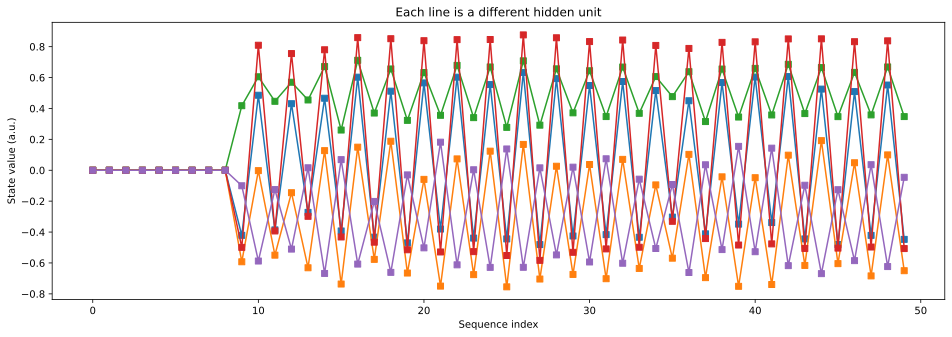

In [19]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

In [20]:
# test with new data
# Create new data WITH FLIPPED SIGNS!
newdata = tr.zeros(N)
for i in range(N):
  newdata[i] = tr.rand(1) * (-1)**(i+1)

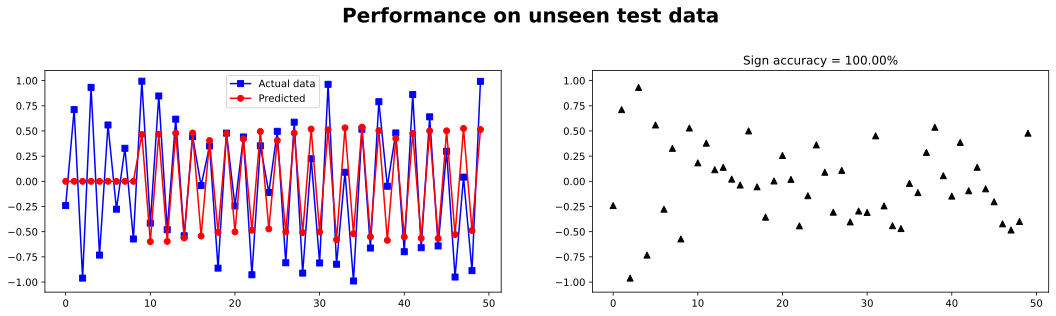

In [21]:
## now test the network!
# note: no learning here!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

  # grab a snippet of data
  X = newdata[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(newdata,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

In [24]:
range(num_hidden)

range(0, 5)

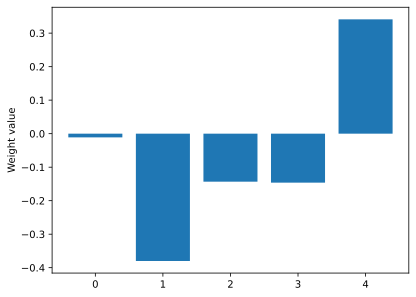

In [27]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach().squeeze())
plt.ylabel('Weight value')
plt.show()

**Additional Explorations**

In [ ]:
# 1) Is the model overfitting? One way to check is by setting the signs to be random instead of alternating. You can do this by modifying the data-generation code to normal random numbers without forcing the sign. What is the predicted accuracy level in this case?
 
# 2) The hidden state is typically initialized to zeros. Is that really the best initialization? Weights are initialized to random numbers. What happens if you initialize the hidden state to randn()? Run the model several times to get a sense of the general trends. Now try initializing to all 100 (instead of zeros). Why are you getting these results?
 
# 3) The data problem here (predicting alternating signs) is pretty easy. Would this same model architecture perform as well for more complicated sequences? As a start, modify the data-generating code to have the sequence ++- (thus, two positive numbers and a negative number, then repeat that sign-pattern over and over again). Once you have this code, you can test a variety of sign-sequencies, like ++--, --+, ++---, etc. Lots of fun to be had ;)
 
# 4) I set the sequence length to be 9. Do you think that's a good value here? Of course, this is a metaparameter that you can pick, and the exact numerical value is a bit arbitrary. But some values are more appropriate than other values, depending on the nature of the data. Based on what you know about our sequence data, what do you think about the value of 9? What sequence lengths would be appropriate for the suggested sequences in question #3?  